# Data Science Challenge: Analysis of ETA

In [1]:
## import packages
import numpy as np
import pandas as pd

import operator
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

# Data Preparation

ETA accuracy can be measured by the difference between the ETA and the actual time to arrival (ATA). For simplicity, we take the absolute difference and refer to it as difference in time to arrival (DTA). To prepare the data sets for downstream analysis, we perform the following steps:
- Merge the trips for driver and rider and attach the features about city metrics
- Remove $\sim 10.9\%$ of trips with missing values to avoid special handling of missing data
- Compute DTA and convert categorical features from string to integer

After the preprocessing steps, the variables in the data set are summarized as follows: 

1) Categorical: *trip_status*, *start_geo*, *end_geo*, *timestamp*(i.e., hour of the trip requested time)

2) Numerical: 
- Trip: ATA, ETA, DTA, *surge_multipler*, *driver payout*, *trip_price_pre_discount*, *rider_payment*
- Driver: *lifetime_rating*, *lifetime_fares*  
- Rider: *lifetime_trips*, *lifetime_payments*, 
- City: *requests*, *trips*, *supply_hours*, *mean_surge_multipler*

3) Unused: *first_completed_trip*, *first_trip_city_id*

We present the summary statistics for each variable in the Table *Summary Statistics*. Note that there are several columns with maximum values far greater than the mean/median and with mean greater than median, suggesting highly right-skewed distribution for those variables. Additionally, the scales of different variables vary dramatically, so that variable transformation may be necessary if we build a linear model downward. 

In [2]:
## Import datasets
driver_trip = pd.read_excel('data_set_6.5.xlsx', sheet_name='driver_trips')
rider_trip = pd.read_excel('data_set_6.5.xlsx', sheet_name='rider_trips')
driver_data = pd.read_excel('data_set_6.5.xlsx', sheet_name='driver_data')
rider_data = pd.read_excel('data_set_6.5.xlsx', sheet_name='rider_data')
city_metric = pd.read_excel('data_set_6.5.xlsx', sheet_name='city_metrics')

In [3]:
## Merge trips and demographics info for driver and rider, respectively
df_driver = driver_trip.merge(driver_data, how='inner', on='driver_id', suffixes=('_trip', '_data'))
df_rider = rider_trip.merge(rider_data, how='inner', on='rider_id', suffixes=('_trip', '_data'))

## Merge trips for driver and rider
df_trips = df_driver.merge(df_rider, how='inner', on='trip_id', suffixes=('_driver', '_rider'))
df_trips = df_trips[~df_trips['trip_id'].duplicated(keep='first')]

In [4]:
## Make a dictionary for city metrics with timestamp as Key
dic = city_metric.set_index('timestamp').T.to_dict()

## Attach city metrics to trips
def attachCityMetrics(x):
    x = x.round('H')
    if dic.has_key(x):
        return x.hour, dic[x]['requests'], dic[x]['trips'], dic[x]['supply_hours'], dic[x]['mean_surge_multipler']
    else:
        return x.hour, None, None, None, None
    
df_trips['timestamp'], df_trips['requests'], df_trips['trips'], df_trips['supply_hours'], df_trips['mean_surge_multipler'] = zip(*df_trips['request_time_rider'].apply(attachCityMetrics))

In [5]:
## Remove trips with missing data
## Most of the missing values come from the features: actual_time_to_arrival and estimated_time_to_arrival
df_trips_full = df_trips[(df_trips['actual_time_to_arrival'].notnull()) & (df_trips['estimated_time_to_arrival'].notnull()) & 
                        (df_trips['lifetime_rating'].notnull()) & (df_trips['lifetime_trips'].notnull()) & (df_trips['requests'].notnull())]

df_trips_full['diff_time_to_arrival'] = abs(df_trips_full['actual_time_to_arrival'] - df_trips_full['estimated_time_to_arrival'])
df_trips_full['start_geo'] = df_trips_full['start_geo_driver'].factorize(sort=True)[0]
df_trips_full['end_geo'] = df_trips_full['end_geo_driver'].factorize(sort=True)[0]
print 'Summary Statistics'
df_trips_full.describe()

Summary Statistics


,actual_time_to_arrival,surge_multiplier_driver,driver payout,lifetime_rating,lifetime_fares,lifetime_completed_trips,estimated_time_to_arrival,surge_multiplier_rider,trip_price_pre_discount,rider_payment,lifetime_trips,first_trip_city_id,lifetime_payments,timestamp,diff_time_to_arrival,start_geo,end_geo
count,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000,51256.000000,51279.000000,51279.000000,51279.000000,51279.000000,51279.000000
mean,2.566665,1.166754,6.061294,4.772767,40653.541118,3756.437587,3.031695,1.166754,7.576618,7.389697,273.416194,30.716697,2876.396876,14.225843,1.126265,1.647712,1.651163
std,2.406494,0.339848,3.522615,0.104540,46581.657383,3506.330592,1.903610,0.339848,4.403269,4.336436,391.699811,79.929243,4309.263962,6.361691,1.210601,0.862894,0.862635
min,0.016667,1.000000,0.000000,2.550000,22.712000,2.000000,0.016667,1.000000,0.000000,0.000000,1.000000,1.000000,3.272000,0.000000,0.000000,0.000000,0.000000
25%,0.800000,1.000000,4.236800,4.724138,10955.776000,1137.500000,1.650000,1.000000,5.296000,5.296000,59.000000,8.000000,597.234226,10.000000,0.466667,2.000000,2.000000
50%,1.900000,1.000000,5.062400,4.789664,25640.056000,2662.000000,2.683333,1.000000,6.328000,6.120000,169.000000,8.000000,1642.488000,15.000000,0.900000,2.000000,2.000000
75%,3.666667,1.200000,6.995200,4.841270,53565.848000,5287.000000,4.016667,1.200000,8.744000,8.532000,366.000000,8.000000,3554.828000,19.000000,1.383333,2.000000,2.000000
max,35.683333,4.800000,67.635200,5.000000,579564.448000,24701.000000,51.716667,4.800000,84.544000,76.089600,16141.000000,1543.000000,139337.616000,23.000000,46.450000,3.000000,3.000000


## Univariate Analysis for ETA Accuracy 

We first perform univaraite analysis to investigate the relationship between DTA and other features. As shown in the Correlation Table, DTA is highly correlated with ETA, which is unsupprising as larger ETA typically suggests more difficulty in *time_to_arrival* estimation. Also, we observe that *surge_multiplier* correlates weakly with DTA. To examine when the ETA forecast tends to work well, we make the boxplot for DTA by binning ETA and the *mean_surge_multipler* (we don't use *surge_multiplier* because there are too many ties) according to their percentiles. Additionally, we make the boxplot for DTA at different strating locations and at different hours of trip request time. Figure *Boxplot_dta.png* shows that
- The accuracy of ETA decreases significantly as the ETA value increases
- The accuracy of ETA decreases slightly as the surge multiplier increases 
- ETA is more accurate for trips starting at Allen Abby and Daisy Drive, compared with trips starting at Blair Bend and Chelsea Court.
- ETA is more accurate at night (19:00-07:00) compared with that in the daytime (08:00-18:00).  

In [6]:
## Correlation between DTA and other features
features_univariate = ['estimated_time_to_arrival', 'surge_multiplier_driver', 'driver payout', 'trip_price_pre_discount', 'rider_payment',
                      'lifetime_rating', 'lifetime_fares', 'lifetime_trips', 'lifetime_payments',
                      'requests', 'trips', 'supply_hours', 'mean_surge_multipler']
corr_dict = dict()
for col in features_univariate:
    corr_dict[col] = np.round(df_trips_full['diff_time_to_arrival'].corr(df_trips_full[col].astype('float64')), 5)
df_corr = pd.DataFrame(corr_dict, index=['diff_time_to_arrival'])
print 'Correlation Table'
df_corr

Correlation Table


,driver payout,estimated_time_to_arrival,lifetime_fares,lifetime_payments,lifetime_rating,lifetime_trips,mean_surge_multipler,requests,rider_payment,supply_hours,surge_multiplier_driver,trip_price_pre_discount,trips
diff_time_to_arrival,0.02135,0.39984,-0.00871,-0.02061,-0.01883,-0.02178,0.04685,0.01672,0.01994,0.03425,0.07769,0.02135,0.01547


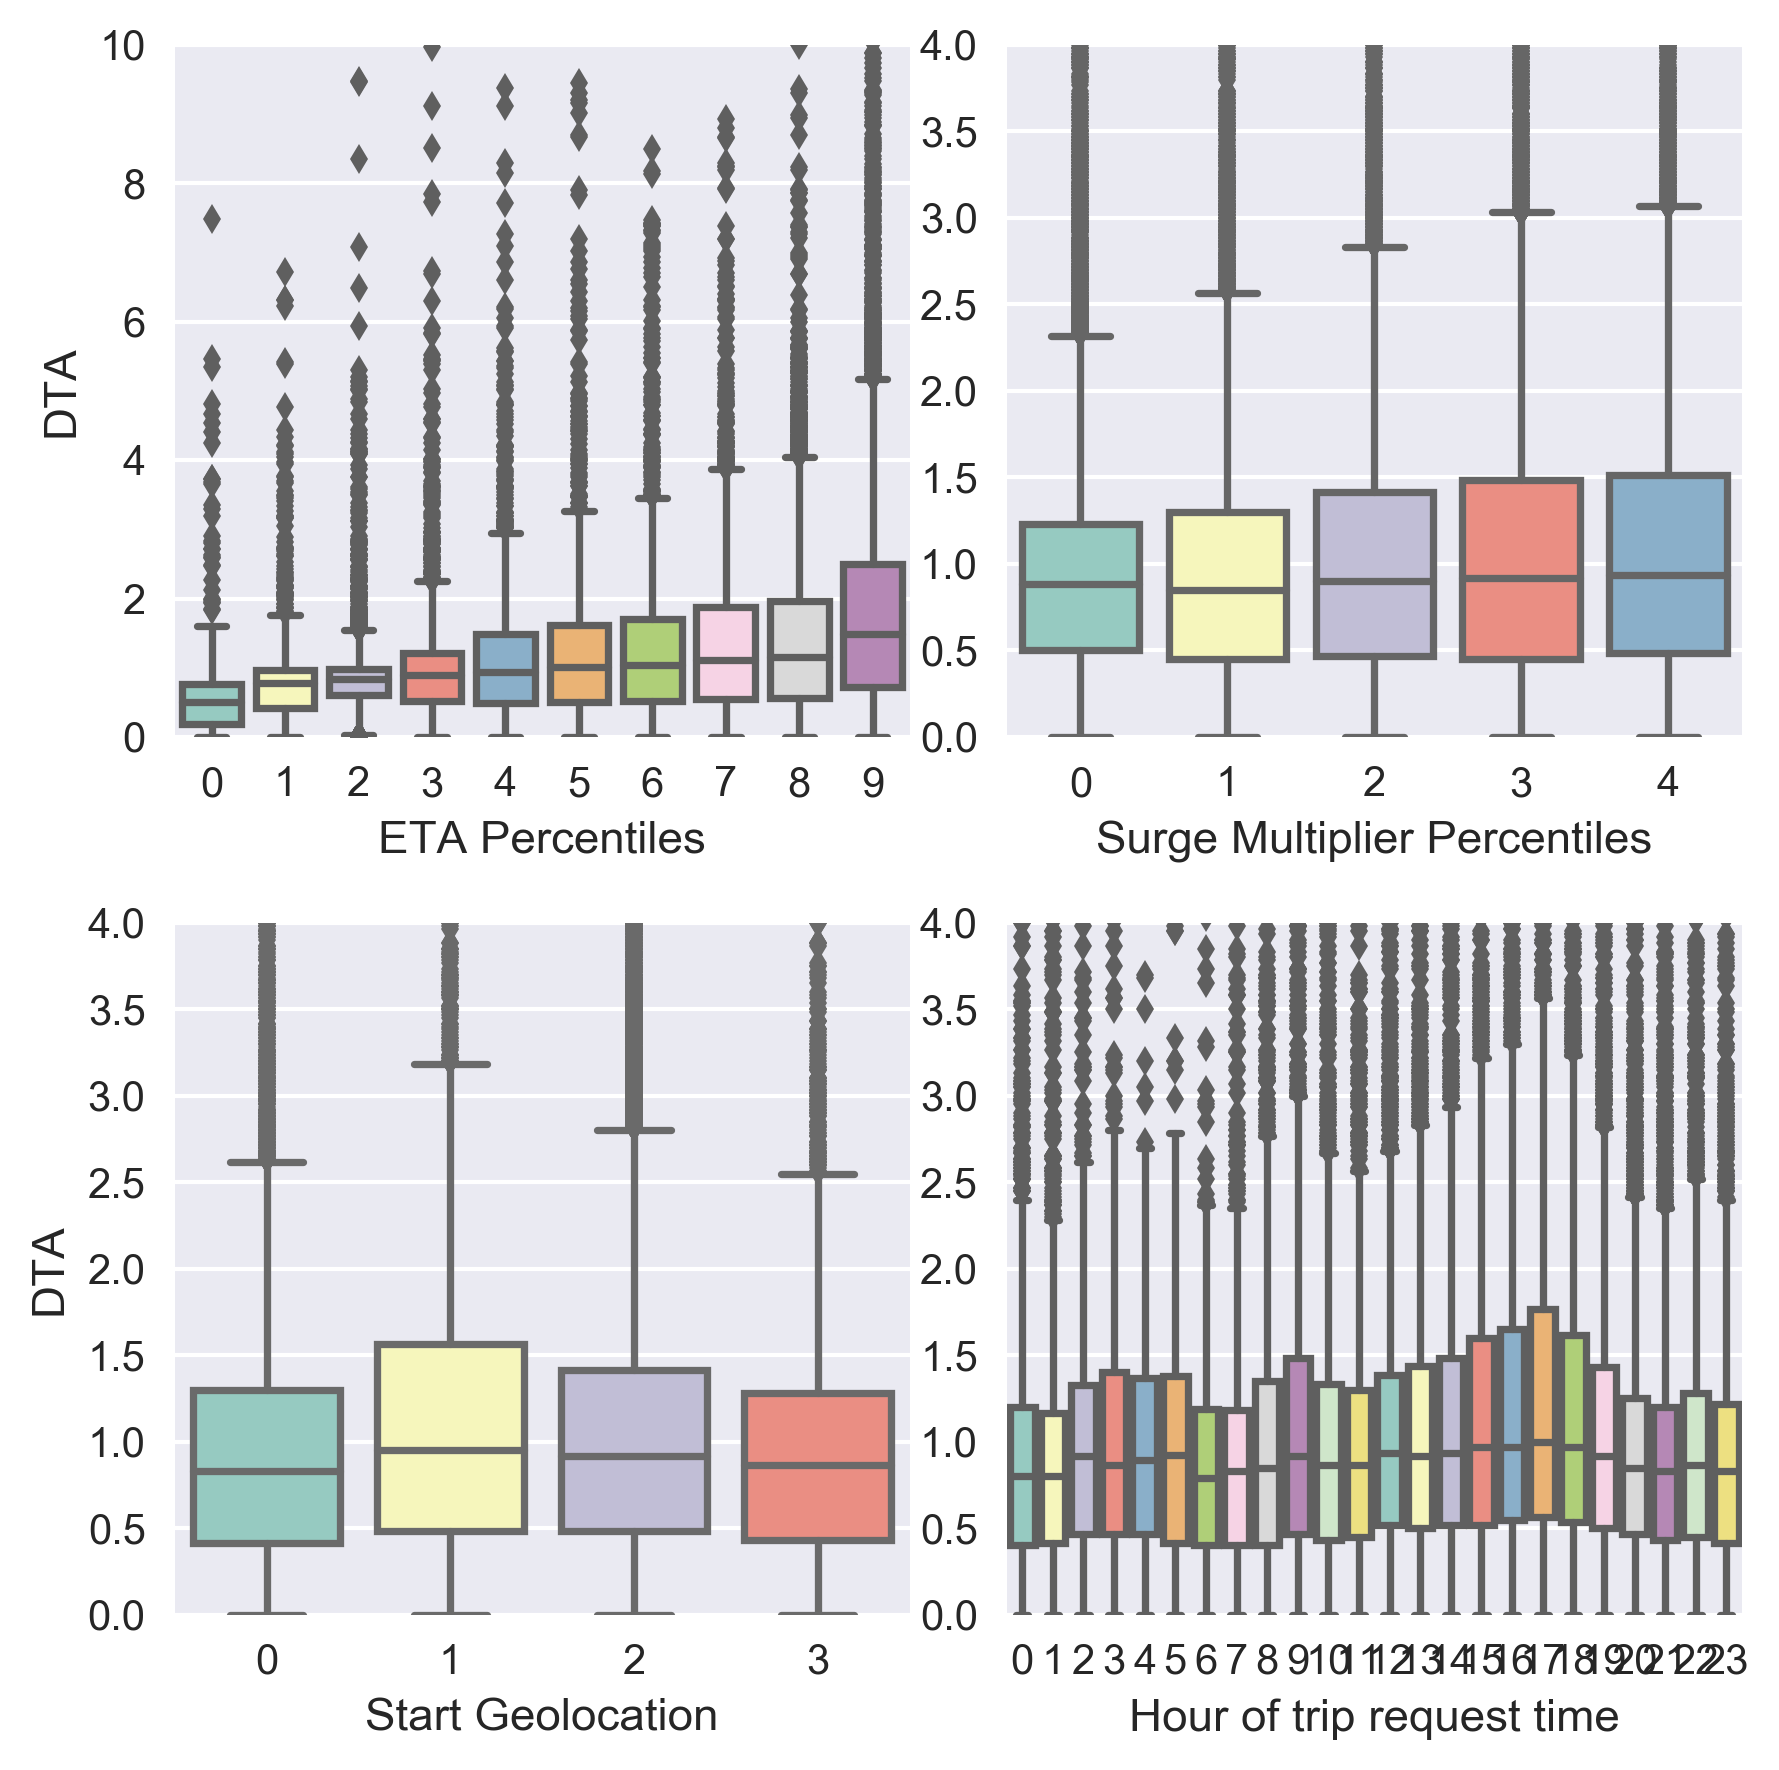

In [7]:
## Cut ETA and surge multiplier into bins using percentiles
n_qcut_eta = 10
n_qcut_sm = 5
df_trips_full['eta_level'] = pd.qcut(df_trips_full['estimated_time_to_arrival'], n_qcut_eta, labels=range(n_qcut_eta))
df_trips_full['sm_level'] = pd.qcut(df_trips_full['mean_surge_multipler'], n_qcut_sm, labels=range(n_qcut_sm))


f, ax = plt.subplots(2, 2, figsize=(6, 6), dpi=300)
sns.boxplot(x='eta_level', y='diff_time_to_arrival', data=df_trips_full, ax=ax[0,0], palette='Set3')
ax[0,0].set_ylim([0,10])
ax[0,0].set_xlabel('ETA Percentiles')
ax[0,0].set_ylabel('DTA')
sns.boxplot(x='sm_level', y='diff_time_to_arrival', data=df_trips_full, ax=ax[0,1], palette='Set3')
ax[0,1].set_ylim([0,4])
ax[0,1].set_xlabel('Surge Multiplier Percentiles')
ax[0,1].set_ylabel('')
sns.boxplot(x='start_geo', y='diff_time_to_arrival', data=df_trips_full, ax=ax[1,0], palette='Set3')
ax[1,0].set_ylim([0,4])
ax[1,0].set_xlabel('Start Geolocation')
ax[1,0].set_ylabel('DTA')
sns.boxplot(x='timestamp', y='diff_time_to_arrival', data=df_trips_full, ax=ax[1,1], palette='Set3')
ax[1,1].set_ylim([0,4])
ax[1,1].set_xlabel('Hour of trip request time')
ax[1,1].set_ylabel('')
plt.tight_layout()
f.savefig('Boxplot_dta.png')

# Impact of ETA Accuracy

To examine the impact of ETA accuracy on rider cancellation, we assign trips into ten equal groups based on the percentiles of DTA. Within each group, we compute the rate of cancellation and plot the rate against the percentile level. Figure *Cancel_rate_vs_dta_pct.png* shows that the rate of rider cancellation tends to increase as ETA becomes more inaccurate (i.e., DTA increases), however, the increasing trend is not consistent because a sudden drop in the rate of cancellation is observed at percentile level 7 and 8. Special attention should be paid to understand what causes the drop.

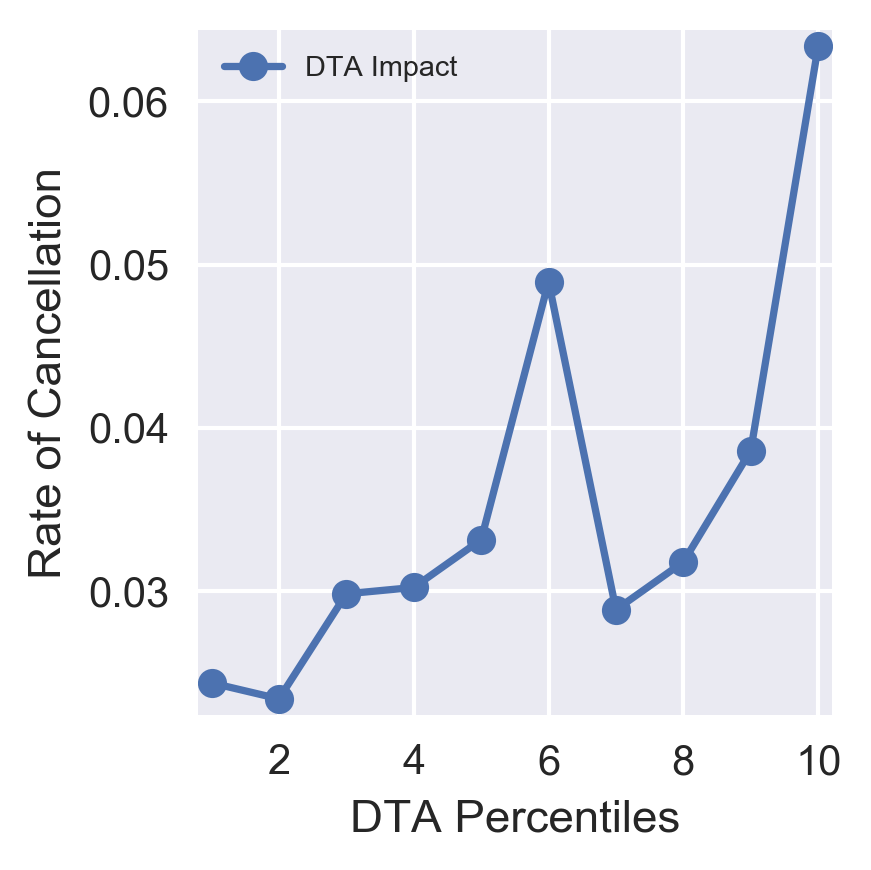

In [8]:
## Add small random noise to avoid ties in qcut
n_qcut = 10
df_trips_full['dta_level'] = pd.qcut(df_trips_full['diff_time_to_arrival']+0.0000001*np.random.normal(size=df_trips_full.shape[0]), n_qcut, labels=range(n_qcut))

cancel_rate = []
for it in range(n_qcut):
    df_dta = df_trips_full[df_trips_full['dta_level']==it]
    rate_dta = df_dta[df_dta['trip_status_driver']=='rider_canceled'].shape[0]/float(df_dta.shape[0])
    cancel_rate.append(rate_dta)
    
f, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=300)
plt.plot(range(1,n_qcut+1), cancel_rate, 'o-', label='DTA Impact')
ymin, ymax = min(cancel_rate)-0.001, max(cancel_rate)+0.001  
ax.set_xlim(0.8, n_qcut+0.2)
ax.set_ylim(ymin, ymax)
plt.legend(loc='upper left', fontsize='x-small')
plt.xlabel('DTA Percentiles')
plt.ylabel('Rate of Cancellation')
plt.tight_layout()
f.savefig('Cancel_rate_vs_dta_pct.png')

# Improving Prediction of ETA

To improve the accuracy of the existing ETA estimate, we build a gradient boosting machine (GBM) model in which the existing ETA estimate is included as a feature (we fail to find a better model for ETA without using the existing ETA as a feature). We choose to use GBM for three reasons: first, we want to learn the nonlinear relationship between ATA and the predictors. As shown in the Figure *Scatterplot_ATA.png*, except ETA, there is not an obvious linear relationship between ATA and other variables. Second, there is no need to perform complex variable transformations using GBM. Third, as a particular ensemble, GBM performs very well in practice.

Specifically, we use LightGBM, a highly efficient gradeint boosting decision tree. In our training process, we perform a grid search to find out the best parameters for maximum tree depth and the learning rate. After picking the optimal parameters, we use $80\%$ of the data to train the model, and evaluate the performance of the model using the remaining $20\%$ of data. This $20\%$ of data is also used to compare the estimation accuracy of the new ETA and the existing ETA. We repeat the procedure five times to obtain the average mean squared error (MSE).  

Some conclusions we draw are:

- The new model reduces the MSE of ETA by **$14.54\%$**, compared with the existing ETA estimate.

- In the new model, the exisitng ETA is the most important feature (see Figure *Metrics_and_feature_importance.png*). Besides the existing ETA, the *driver payout*, the *timestamp* (hour of the trip request time), the driver's *lifetime_fares*, and *mean_surge_multiplier*, are also very important in predicting more accurate ETA.

GBM has the tendency of overfitting the data. To address the concern of overfitting, alternatively, we have used random forest to predict ETA for which the results are comparable with those of LightGBM. As a result, we don't present them here. To further improve the prediction of ETA, we should collect data on other external factors such as weather (e.g., wind speed, rain or not), traffic conditions, road construction information, and special holidays or events, etc.  

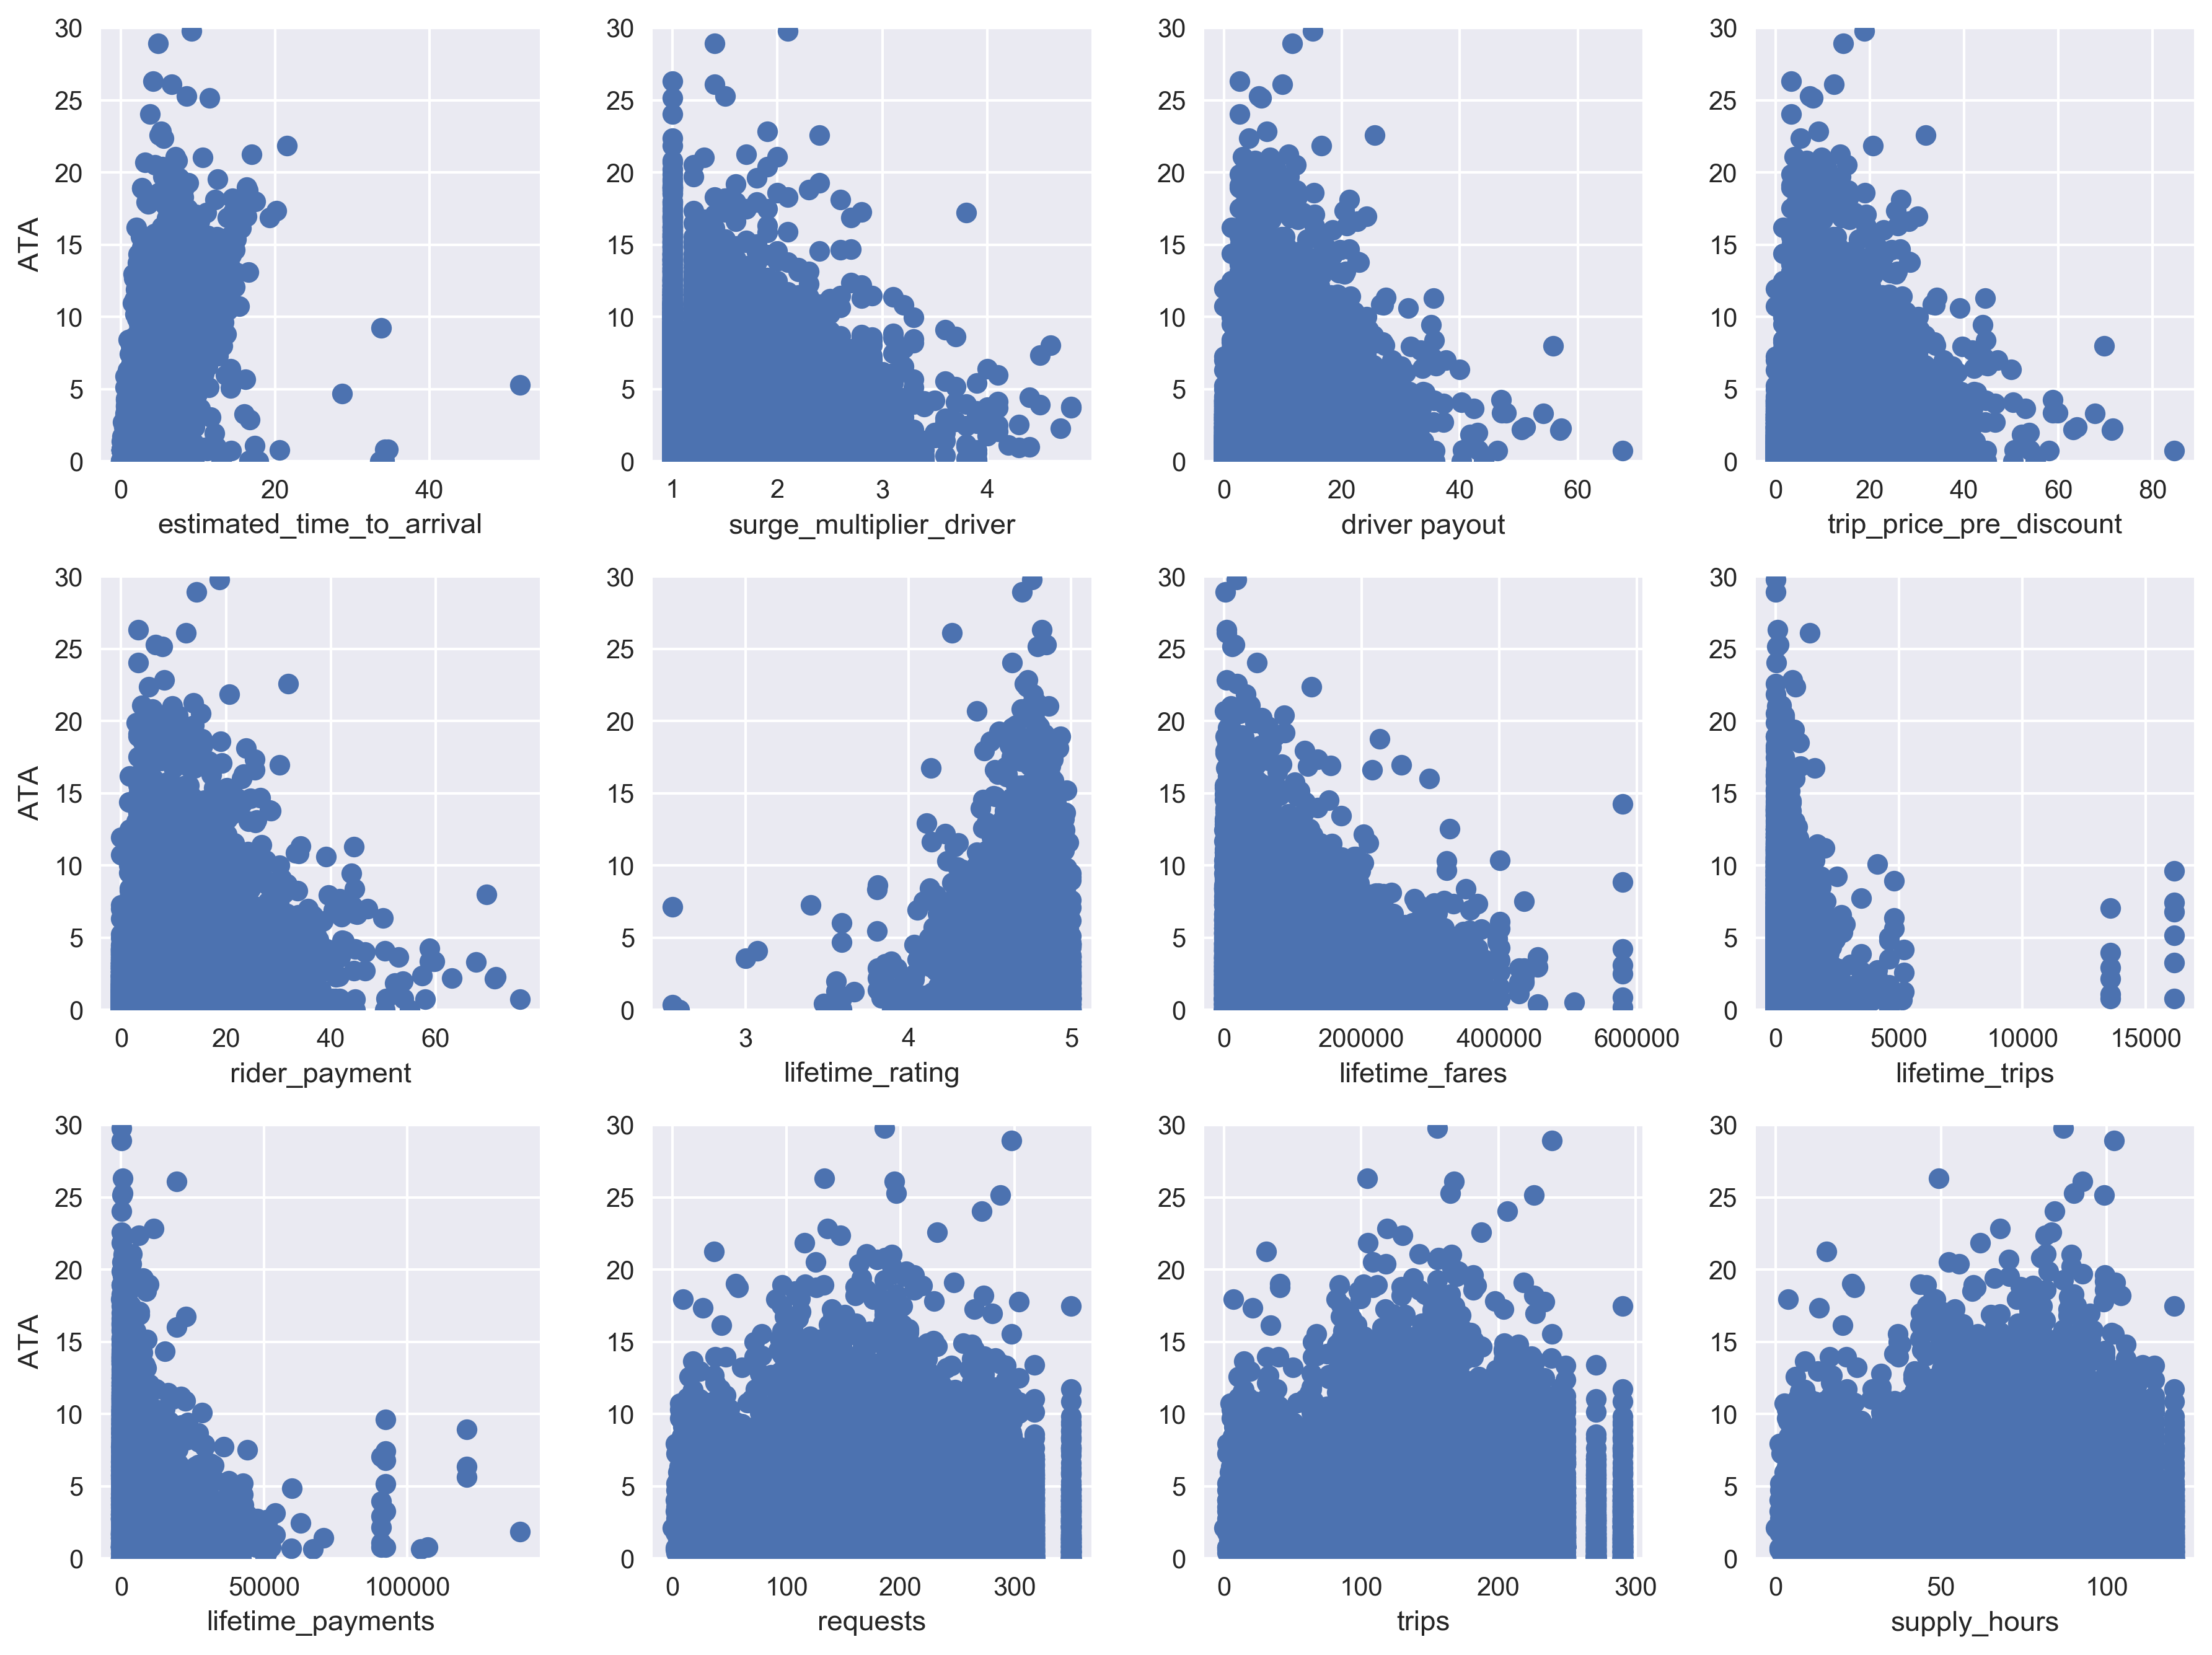

In [9]:
feature_set = ['estimated_time_to_arrival', 'surge_multiplier_driver', 'driver payout', 'trip_price_pre_discount', 'rider_payment', 'lifetime_rating', 'lifetime_fares', 
                'lifetime_trips', 'lifetime_payments', 'requests', 'trips', 'supply_hours']
f, ax = plt.subplots(3, 4, figsize=(12, 9), dpi=300)
axs = ax.ravel()
for i in range(12):
    feature = feature_set[i]
    axs[i].plot(df_trips_full[feature].values, df_trips_full['actual_time_to_arrival'].values, 'o', markersize=8)
    if i%4 == 0:
        axs[i].set_ylabel('ATA')
    axs[i].set_xlabel(feature)
    axs[i].set_ylim([0,30])
plt.tight_layout()
f.savefig('Scatterplot_ATA.png')

In [10]:
## Create lgb data object
feature_name = ['estimated_time_to_arrival', 'surge_multiplier_driver', 'driver payout', 'trip_price_pre_discount', 'rider_payment', 'lifetime_rating', 'lifetime_fares', 
                'lifetime_trips', 'lifetime_payments', 'requests', 'trips', 'supply_hours', 'mean_surge_multipler', 'timestamp', 'start_geo', 'end_geo']

X_train = df_trips_full[feature_name].values
y_train = df_trips_full['actual_time_to_arrival'].values
lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=feature_name, categorical_feature=[13, 14, 15], free_raw_data=False)

In [11]:
## Search best parameter value for depth and learning rate
k_fold = 5
stats = dict()
for depth in [4, 6, 8]:
    for lr in [0.05, 0.1]:
        mse = []
        parameters = {'boosting_type': 'gbdt', 'objective': 'regression', 'application': 'regression_l2', 'metric': 'mse',
                      'max_depth': depth, 'num_leaves': int(2 ** depth * 0.8), 'verbose': 0, 'min_data_in_leaf': 20,
                      'learning_rate': lr, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5}
        
        ## k-fold cv
        for k in range(k_fold):
            lgb_cv = lgb.cv(params=parameters, train_set=lgb_train, num_boost_round=200, nfold=k_fold, early_stopping_rounds=10, 
                            stratified=False, verbose_eval=None, seed=k)
            mse.append(min(lgb_cv['l2-mean']))
        stats[(depth, lr)] = np.mean(mse)
        
(best_depth, best_lr), mse = sorted(stats.items(), key=lambda x: x[1])[0]
print 'Best depth {}, best learning rate {}, and the resulting MSE: {}'.format(best_depth, best_lr, mse)

Best depth 4, best learning rate 0.05, and the resulting MSE: 2.26824155084


In [12]:
params = {'boosting_type': 'gbdt', 'objective': 'regression', 'application': 'regression_l2', 'metric': 'mse',
          'max_depth': best_depth, 'num_leaves': int(2 ** best_depth * 0.8), 'verbose': 0, 'min_data_in_leaf': 20,
          'learning_rate': best_lr, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5}

mse_lgb = []
mse_eta = []
rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=11)
for trainIndex, testIndex in rs.split(df_trips_full):
    X_Train = df_trips_full[feature_name].iloc[trainIndex].values
    y_Train = df_trips_full['actual_time_to_arrival'].iloc[trainIndex].values

    X_Test = df_trips_full[feature_name].iloc[testIndex].values
    y_Test = df_trips_full['actual_time_to_arrival'].iloc[testIndex].values

    lgb_Train = lgb.Dataset(X_Train, y_Train, feature_name=feature_name, categorical_feature=[13, 14, 15], free_raw_data=False)
    lgb_Test = lgb.Dataset(X_Test, y_Test, reference=lgb_Train, feature_name=feature_name, categorical_feature=[13, 14, 15], free_raw_data=False)

    evals_result = {} # to record eval results for plotting
    gbm = lgb.train(params, train_set=lgb_Train, num_boost_round=200, valid_sets=lgb_Test, 
                    evals_result=evals_result, verbose_eval=None, early_stopping_rounds=10)
    y_pred = gbm.predict(X_Test)
    mse_lgb.append(mean_squared_error(y_Test, y_pred))
    mse_eta.append(mean_squared_error(y_Test, df_trips_full['estimated_time_to_arrival'].iloc[testIndex].values))

The average MSE of LightGBM prediction is: 2.22332051478
The average MSE of existing ETA is: 2.60155258168
The percentage of decrease in MSE is: 14.54%
Metrics recorded during training and Feature importance of the model


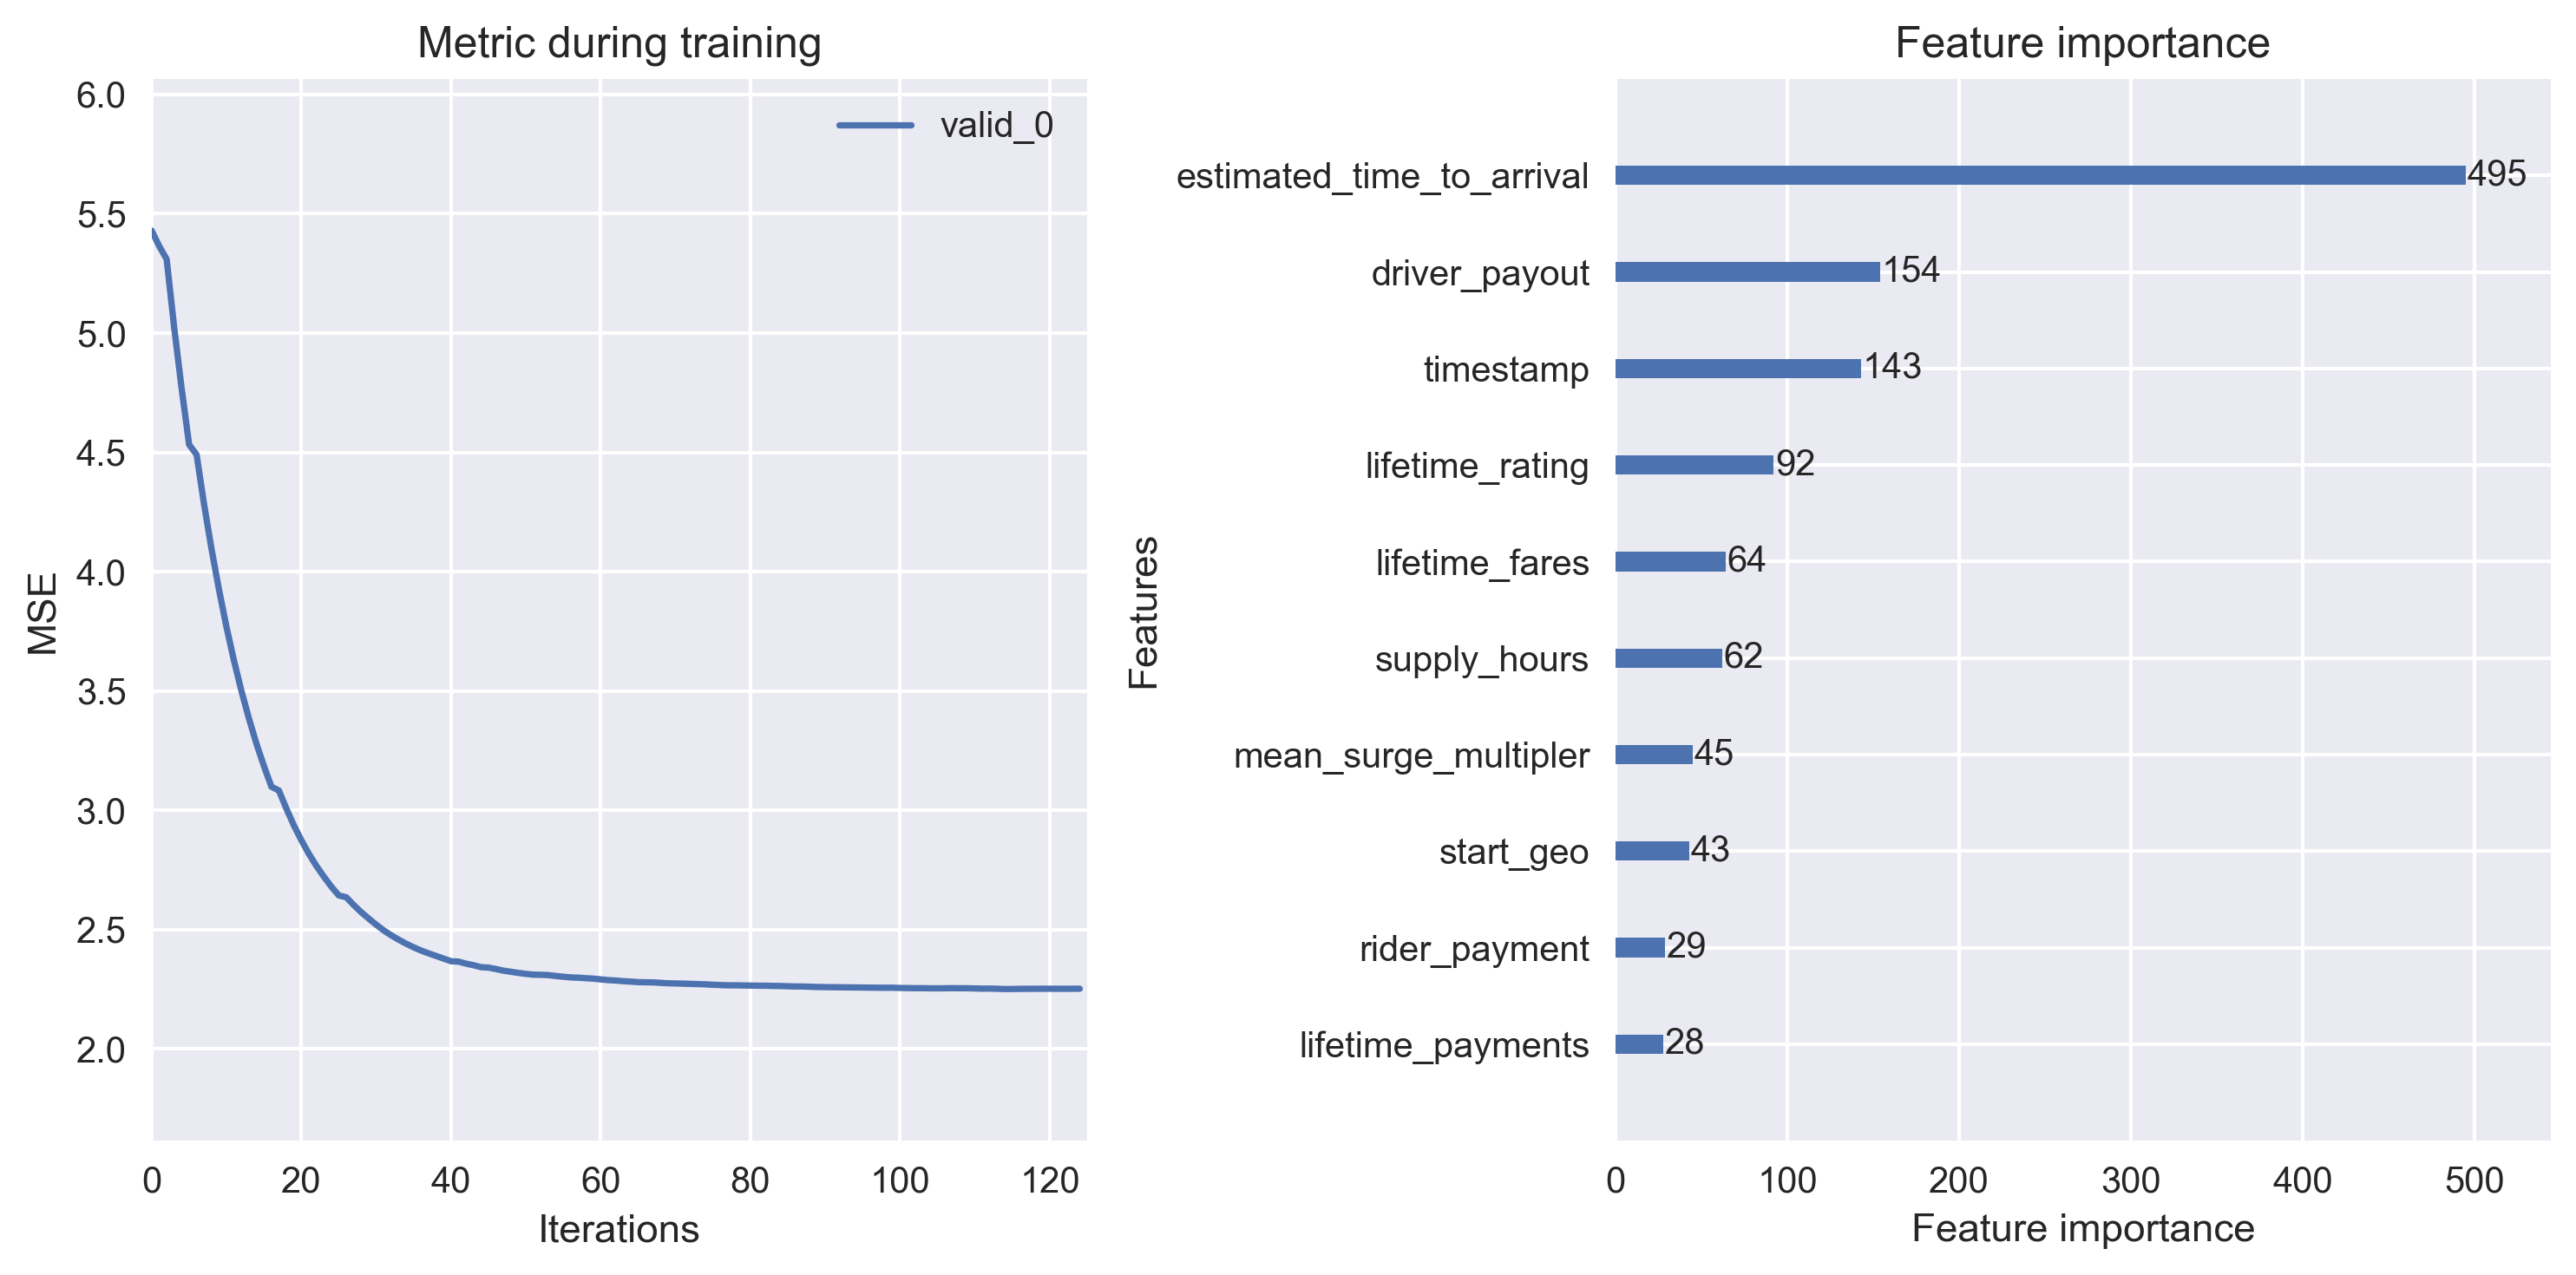

In [13]:
## Evaluate the performance 
features = {key:value for key, value in zip(gbm.feature_name(), gbm.feature_importance())}
features_sorted = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
print 'The average MSE of LightGBM prediction is: {}'.format( np.mean(mse_lgb) )
print 'The average MSE of existing ETA is: {}'.format( np.mean(mse_eta) )
print 'The percentage of decrease in MSE is: {0:.2f}%'.format( (np.mean(mse_eta)-np.mean(mse_lgb))*100/np.mean(mse_eta) )
print 'Metrics recorded during training and Feature importance of the model'
f, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
lgb.plot_metric(evals_result, metric='l2', ax=ax[0])
ax[0].set_ylabel('MSE')
lgb.plot_importance(gbm, ax=ax[1], max_num_features=10)
plt.tight_layout()
f.savefig('Metrics_and_feature_importance.png')

# Design of Experiment to Estimate the Impact

To evaluate the impact of the new ETA estimate on the marketplace, the key metrics we should measure include:
- The actual improvement of the new ETA estimate over the exisitng one
- The average driver's earnings
- The rate of ride cancellation

The improvement of the new ETA estimate and the rate of ride cancellation would be computed per trip while the average driver's earning would be computed per driver.

## Experiment design
We conduct A/B testing by exposing riders to the new and existing ETA estimates at different days. Such a design can match confounding factors such as the driver, the traffic conditions, the weather etc., between the exposers and non-exposers. Theoretically, some rider (driver) may be assigned into exposed and non-exposed at different days (the probability is actually very low given a large number of trips per day), however, this experiment is still a valid randomized control trial. The detailed steps are as follows: 
- On day one, we randomly pick 144 trips (select one trip per 10 minutes), and expose rider to the new ETA estimate;
- On day two, we randomly pick 144 trips similarly and expose rider to the existing ETA estimate;
- On day three, we randomly pick 144 trips similarly and expose rider to the new ETA estimate;
- On day four, we randomly pick 144 trips similarly and expose rider to the existing ETA estimate;
- ...

We conduct the above experiment over a fixed time horizon, which is determined by several factors including statistical power, minimal detectable difference in a metric, etc.  
In analyzing the collected data, to handle potential multiple hypothesis testing problem, we might use a Bonferonni-type correction or false discovery rate.

## Boosting using XGBoost

In [ ]:
## create xgb data object
feature_name = ['estimated_time_to_arrival', 'surge_multiplier_driver', 'driver payout', 'trip_price_pre_discount', 'rider_payment', 'lifetime_rating', 'lifetime_fares', 
                'lifetime_trips', 'lifetime_payments', 'requests', 'trips', 'supply_hours', 'mean_surge_multipler', 'timestamp', 'start_geo', 'end_geo']

X_train = df_trips_full[feature_name].values
y_train = df_trips_full['actual_time_to_arrival'].values
xg_train = xgb.DMatrix(X_train, y_train)

In [ ]:
n_folds = 5
stats_xgb = {}
for depth in [4, 6, 8]:
    for lr in [0.05, 0.1]:
        mse = []
        parameters = {'eta': lr, 'max_depth': depth, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'reg:linear', 'silent': 1, 
              'eval_metric':'rmse', 'nthread':4}
        
        ## k-fold cv
        for k in range(n_folds):
            xgb_cv = xgb.cv(parameters, xg_train, 200, nfold=n_folds, early_stopping_rounds=10, verbose_eval=None, 
                            feature_name=feature_name, seed=k)
            mse.append(np.square(min(xgb_cv['test-rmse-mean'])))
        stats_xgb[(depth, lr)] = np.mean(mse)

(best_depth, best_lr), mse = sorted(stats_xgb.items(), key=lambda x: x[1])[0]
print 'Best depth {}, best learning rate {}, and the resulting MSE: {}'.format(best_depth, best_lr, mse)

In [ ]:
feature_name_x = ['x{}'.format(i) for i in range(len(feature_name))]
params = {'eta': best_lr, 'max_depth': best_depth, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'reg:linear', 'silent': 1, 
              'eval_metric':'rmse', 'nthread':4}

mse_xgb = []
mse_eta = []
rs = ShuffleSplit(n_splits=5, test_size=0.2, random_state=11)
for trainIndex, testIndex in rs.split(df_trips_full):
    X_Train = df_trips_full[feature_name].iloc[trainIndex].values
    y_Train = df_trips_full['actual_time_to_arrival'].iloc[trainIndex].values

    X_Test = df_trips_full[feature_name].iloc[testIndex].values
    y_Test = df_trips_full['actual_time_to_arrival'].iloc[testIndex].values

    xgb_Train = xgb.DMatrix(X_Train, y_Train, feature_names=feature_name_x)
    xgb_Test = xgb.DMatrix(X_Test, y_Test, feature_names=feature_name_x)
    
    evals_result = {}
    model = xgb.train(params=params, dtrain=xgb_Train, num_boost_round=200, evals=[(xgb_Train, 'train'), (xgb_Test, 'test')],
                     evals_result=evals_result, early_stopping_rounds=10, verbose_eval=None)
    
    y_pred = model.predict(xgb_Test)
    mse_xgb.append(mean_squared_error(y_Test, y_pred))
    mse_eta.append(mean_squared_error(y_Test, df_trips_full['estimated_time_to_arrival'].iloc[testIndex].values))

In [ ]:
## visualizing the first tree
f, ax = plt.subplots(1, 1, figsize=(50, 10), dpi=600)
xgb.plot_tree(model,num_trees=0,ax=ax)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()
plt.tight_layout()
f.savefig('first_tree.png')

In [ ]:
## checking the feature importance
f, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
xgb.plot_importance(model, ax=ax)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()
plt.tight_layout()
f.savefig('feature_importance.png')